## Tutorial notebook

***
<span style="color:orange">
This notebook contains the same content as gce_nn_example_notebook.ipynb, but it is meant to be executed in
<a href=https://colab.research.google.com/>Google Colab</a>.  Simply download this Jupyter notebook (<b>without</b> cloning the entire
repository), upload it to your Google Drive, and run it in Google Colab. You can run the notebook on a GPU by selecting "GPU" in <i>Runtime ->
Change runtime type -> Hardware accelerator</i>.
</span>

In [ ]:
# Clone the reposity, enter it, install the prerequisites, and install the GCE NN package
!git clone https://github.com/FloList/GCE_NN
%cd /content/GCE_NN
%pip install -r requirements.txt
!python setup.py install

***


This Jupyter notebook shows how to perform a basic analysis of γ-ray photon-count maps using the convolutional neural network-based method presented in [arXiv:2107.09070](http://arxiv.org/abs/2107.09070). 

In this example, the photon-count maps consist of **three** different emission components:    
1. *Fermi* bubbles (Poissonian)
2. Galactic Center Excess (point source-like, single population)
3. Isotropic point sources (point source-like, two populations in each map).

As discussed in the paper, for the point source-like templates the Poissonian case is included as the limit of ultra-faint point source emission (<< 1 photon expected per source) where the neural network can no longer distinguish point sources from Poissonian emission.

To consider different scenarios (e.g. other templates, more training data, different network architectures, etc.), simply modify the sample parameter file ```GCE_NN/parameter_files/parameters.py``` accordingly.
The available templates can be viewed in the function ```get_templates()``` in ```GCE/data_utils.py```.



In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp
import os
import IPython

In [2]:
%pip list | grep gce-nn   # check if gce-nn module is there
try:
  import GCE.gce
except:
  IPython.Application.instance().kernel.do_shutdown(True) # automatically restarts kernel
  raise RuntimeError("NEED TO RESTART KERNEL TO USE THE INSTALLED PACKAGES! KERNEL WILL BE RESTARTED AUTOMATICALLY... "
                     "PLEASE RE-RUN THE NOTEBOOK TO THIS POINT AND THEN CONTINUE. Exiting now...")

gce-nn                  0.0.1
Note: you may need to restart the kernel to use updated packages.


2021-11-19 09:53:16.871424: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/flo/.pyenv/versions/3.8.0/envs/venv_gce_nn_38/lib/python3.8/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [ ]:
%cd /content/GCE_NN/examples

First, we need to **initialize** an analysis object.

In [ ]:
gce = GCE.gce.Analysis()

Now, let's **load the parameters** from the parameter file in the parameter_files folder.

In [4]:
gce.load_params("/content/GCE_NN/parameter_files/parameters.py")

Loading parameters from '../parameter_files/parameters.py'...
Loading parameters: ['comb' 'data' 'gen' 'mod' 'nn' 'plot' 'train' 'tt']


/home/flo/Documents/Projects/GCE_hist/GCE_NN/GCE/gce.py:272: RuntimeWarning: invalid value encountered in log10
  bin_edges_mapped = np.log10(bin_edges) if self.p.nn.hist["log_spaced_bins"] else bin_edges


We can take a look at the loaded parameters:

In [5]:
gce.print_params()

{'comb': {'N_test': 2,
          'N_val': 2,
          'bins_counts_per_PS': array([-0.5,  2.5,  5.5,  8.5, 11.5, 14.5, 17.5, 20.5, 23.5, 26.5, 29.5,
       32.5, 35.5, 38.5, 41.5, 44.5, 47.5, 50.5, 53.5, 56.5, 59.5,  inf]),
          'bins_counts_per_pix': array([-0.5,  2.5,  5.5,  8.5, 11.5, 14.5, 17.5, 20.5, 23.5, 26.5, 29.5,
       32.5, 35.5, 38.5, 41.5, 44.5, 47.5, 50.5, 53.5, 56.5, 59.5,  inf]),
          'bins_dNdF': array([          -inf, 3.16227766e-13, 5.95662144e-13, 1.12201845e-12,
       2.11348904e-12, 3.98107171e-12, 7.49894209e-12, 1.41253754e-11,
       2.66072506e-11, 5.01187234e-11, 9.44060876e-11, 1.77827941e-10,
       3.34965439e-10, 6.30957344e-10, 1.18850223e-09, 2.23872114e-09,
       4.21696503e-09, 7.94328235e-09, 1.49623566e-08, 2.81838293e-08,
       5.30884444e-08, 1.00000000e-07,            inf]),
          'combine_without_PSF': False,
          'data_name': 'Example_comb',
          'do_counts_per_PS': False,
          'do_counts_per_pix': False,
     

The parameters are stored in gce.p and can also be accessed group-wise. For example, the Poissonian (P) and point-source (PS) templates used in this analysis can be viewed with

In [6]:
gce.p.mod

{'models_P': ['bub'],
 'models_PS': ['gce_12_PS', 'iso_PS'],
 'model_names_P': ['$\\it{Fermi}$ bubbles'],
 'model_names_PS': ['GCE', 'isotropic PS'],
 'models': ['bub', 'gce_12_PS', 'iso_PS'],
 'model_names': ['$\\it{Fermi}$ bubbles', 'GCE', 'isotropic PS'],
 'n_models_P': 1,
 'n_models_PS': 2,
 'n_models': 3}

and the data-related settings (such as the exposure map, the mask for the region of interest, as well as whether the *Fermi* point-spread function at 2 GeV shall be applied) are stored in

In [7]:
gce.p.data

{'outer_rad': 25.0,
 'inner_band': 2.0,
 'leakage_delta': 0.75,
 'mask_type': '3FGL',
 'nside': 128,
 'exposure': 'Fermi',
 'psf': True,
 'npix': 196608}

Now, let's generate some simulated Monte Carlo photon-count maps for each of the templates. The relevant parameters are stored in the field "tt" (training and testing data) - most importantly the priors, as well as the number of maps given by "n_chunk" (each chunk will be saved in a single file) times the number of simulations per chunk.

In [8]:
gce.p.tt

{'data_name': 'Example',
 'filename_base': 'Maps',
 'poisson_A_is_log': False,
 'n_chunk': 100,
 'n_sim_per_chunk': 50,
 'add_two_temps_PS': ['iso_PS'],
 'priors': {'bub': array([0., 2.]),
  'gce_12_PS': {'mean_exp': [-12, -9],
   'var_exp': 0.25,
   'skew_std': 3.0,
   'flux_lims': [0, 1.4e-08],
   'flux_log': False,
   'enforce_upper_flux': True},
  'iso_PS': {'mean_exp': [-12, -9],
   'var_exp': 0.25,
   'skew_std': 3.0,
   'flux_lims': [0, 1.4e-08],
   'flux_log': False,
   'enforce_upper_flux': True}}}

To **generate** the template maps, we can simply run

In [9]:
# Ray settings (for parallelized data generation)
# ray_settings = {"num_cpus": 4, "object_store_memory": 2000000000}
ray_settings = {"num_cpus": 4}  # select the number of CPUs here
gce.generate_template_maps(ray_settings, n_example_plots=5, job_id=0)

Template maps exist already!


Some example maps (whose number is determined by ```n_example_plots``` above) for each template can be viewed in the folder ```GCE_NN/data/Template_maps/Example_128```.

The next step is to **combine** (i.e. sum up) the individual template maps to obtain the final training, validation, and testing maps. Internally, this is done in two steps: 1) the filenames of the template maps for each of these three subsets are stored in a file, and 2) the template maps are combined and saved.

In [10]:
gce.combine_template_maps(save_filenames=True, do_combine=True)

Combined maps exist already!


NOTE: if data has already been generated, the corresponding parameters can be directly loaded from the template maps / combined maps folders, e.g.

```
gce.load_params("/content/GCE_NN/data/Template_maps/Test_128")
gce.load_params("/content/GCE_NN/data/Combined_maps/Test_comb_128")
```


Next, we need to build the **data processing pipeline** that will feed the combined photon-count maps to the neural network.

In [11]:
gce.build_pipeline()

2021-11-19 09:53:20.825489: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-19 09:53:20.844547: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3193965000 Hz


Input pipeline successfully built.


We can use the method ```get_samples()``` to get photon-count maps and their associated labels from the datasets **train** (used for training), **val** (used as an independent validation dataset during training), and **test** (used for testing once the training is finished) 

In [12]:
samples = gce.datasets["test"].get_samples(1)
data, labels = samples["data"], samples["label"]  # samples contains data and labels (flux fractions & SCD histograms)
print("Shapes:")
print("  Data", data.shape)  # n_samples x n_pix_in_ROI
print("  Flux fractions", labels[0].shape)  # n_samples x n_templates
print("  SCD histograms", labels[1].shape)  # n_samples x n_bins x n_PS_templates

Shapes:
  Data (1, 7749)
  Flux fractions (1, 3)
  SCD histograms (1, 22, 2)


Let's take a look at a combined map. The maps are compressed and only contain the pixels that lie within the ROI - the method ```decompress()``` returns the full-sky map that can be fed to the healpy functions.

We will plot 
1. the **photon-count map**, 
2. the rescaled version in **'flux' space** as shown to the neural network (divided by exposure correction), and 
3. the *Fermi* **exposure correction**.

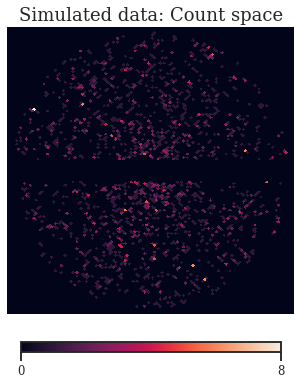

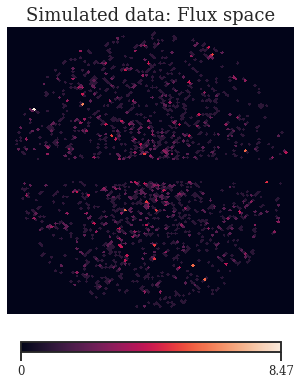

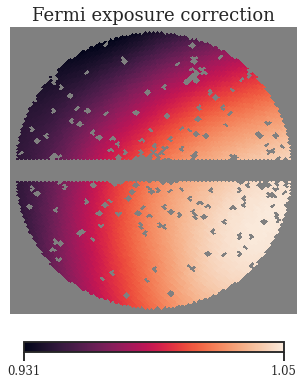

In [13]:
# NOTE: the maps are stored in NEST format
map_to_plot = 0
r = gce.p.data["outer_rad"] + 1
hp.cartview(gce.decompress(data[map_to_plot] * gce.template_dict["rescale_compressed"]), nest=True,
            title="Simulated data: Count space", lonra=[-r, r], latra=[-r, r])
hp.cartview(gce.decompress(data[map_to_plot]), nest=True,
            title="Simulated data: Flux space", lonra=[-r, r], latra=[-r, r])
hp.cartview(gce.decompress(gce.template_dict["rescale_compressed"], fill_value=np.nan), nest=True,
            title="Fermi exposure correction", lonra=[-r, r], latra=[-r, r])
plt.show()

Let's also plot the real *Fermi* map in our region of interest. Of course, it looks quite different from our simulated maps because we only included the *Fermi* bubbles, the GCE, and isotropic point sources in this example (so we are completely ignoring the diffuse Galactic foregrounds, which are responsible for the majority of photon counts).

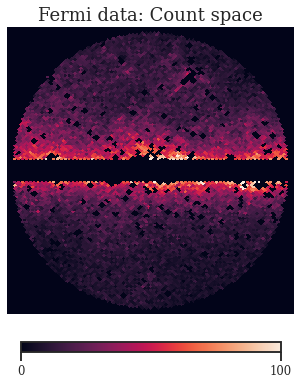

In [14]:
fermi_counts = gce.datasets["test"].get_fermi_counts()
hp.cartview(gce.decompress(fermi_counts * gce.generators["test"].settings_dict["rescale_compressed"]), nest=True,
            title="Fermi data: Count space", max=100, lonra=[-r, r], latra=[-r, r])
# hp.cartview(gce.decompress(fermi_counts), nest=True, title="Fermi data: Flux space", max=100)
plt.show()

Now, it's time to **build** our neural network:


In [15]:
gce.build_nn()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

*NOTE*: Once the neural network has been trained, **loading** is as easy as ```gce.load_nn()```.

In [16]:
# gce.load_nn()

Let's **train** our neural network to predict 
1. the **flux fractions** of the different templates (using a negative maximum log-likelihood loss function), and 
2. the **SCD histograms** of the GCE and isotropic point source populations (using the *Earth Mover's pinball loss*, see [arXiv:2106.02051](https://arxiv.org/abs/2106.02051)).

In [17]:
gce.train_nn("flux_fractions")

Restored checkpoint from ../models/checkpoints/Example_comb_128/Training_1/ff/ckpt-2500.
19 tensor(s) will be trained.
The total number of training steps (2500) has already been reached!


In [18]:
gce.train_nn("histograms")


Two checkpoint references resolved to different objects (<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fb470339490> and <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fb4701a8d90>).
Restored checkpoint from ../models/checkpoints/Example_comb_128/Training_1/hist/ckpt-2500.
19 tensor(s) will be trained.
The total number of training steps (2500) has already been reached!


Finally, let's **evaluate** the performance of our neural network on simulated test data.

In [19]:
n_samples = 20
test_samples = gce.datasets["test"].get_samples(n_samples)
test_data, test_ffs, test_hists = test_samples["data"], test_samples["label"][0], test_samples["label"][1]
tau = np.arange(5, 100, 5) * 0.01  # quantile levels for SCD histograms, from 5% to 95% in steps of 5%
pred = gce.predict(test_data, tau=tau, multiple_taus=True)  # get the NN predictions

2021-11-19 09:53:25.731134: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-11-19 09:53:26.789109: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-11-19 09:53:26.789168: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


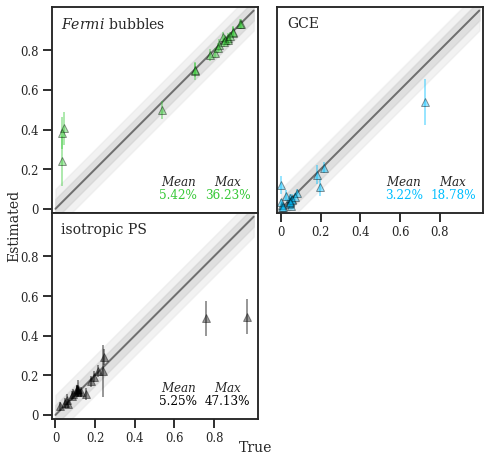

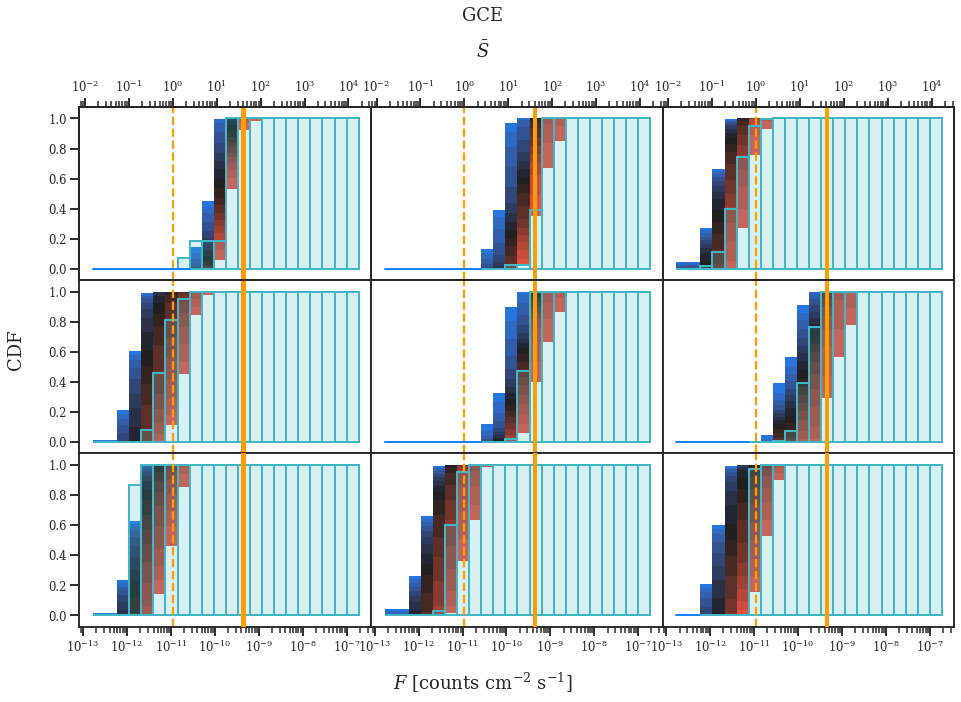

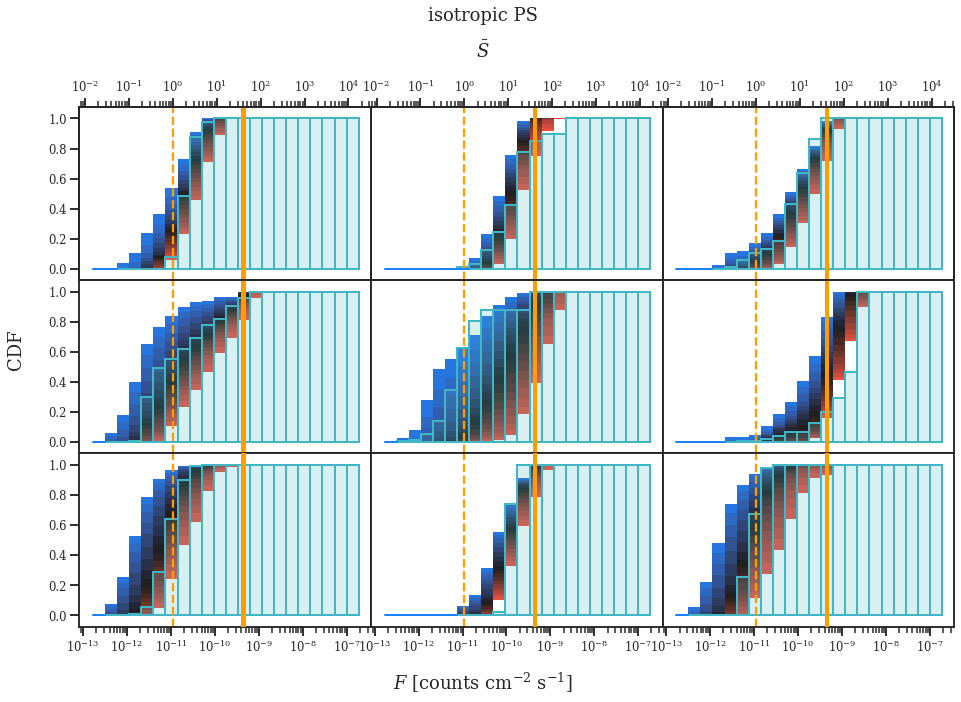

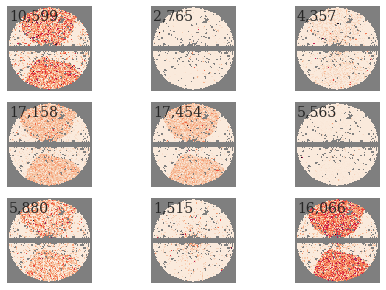

In [20]:
# Make some plots (will be saved in the models folder)
gce.plot_nn_architecture()
gce.plot_flux_fractions(test_ffs, pred)
gce.plot_histograms(test_hists, pred, plot_inds=np.arange(9))
gce.plot_maps(test_data, decompress=True, plot_inds=np.arange(9))
plt.show()

Clearly, the training dataset is too small and the training was too short to obtain accurate and precise predictions. Still, the neural networks have already learned *something*, and the predictions are roughly in the right ballpark.